In [104]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path




In [105]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

AUTOTUNE = tf.data.AUTOTUNE

# Load Data

In [106]:

def load_matrix(file):
    pass

def get_waveform(filepath):
    audio_binary = tf.io.read_file(filepath)
    audio = tf.squeeze(audio_binary)
    waveform, samplerate = tf.audio.decode_wav(audio)
    if (samplerate != 44100):
        print("Incorrect sample rate: " + filepath)
    
    return waveform


### MKA Dataset Functions


In [107]:
def get_MKA_waveforms_and_labels():
    datasetPath = "./MKA datasets"

    excluded_classes = ["start", "menu", "pgdn", "pgup", "delete", "home", "neshanay xwarawa", "neshanay sarawa", "neshanay lay rast", "neshanay lay chap", "caps"]

    mkaWaveforms= []
    mkaLabels= []

    for manufacturer in os.listdir(datasetPath):
        wavChildFolderPath = datasetPath + "/" + manufacturer + "/Sound Segment(wav)"
        caseFolders = os.listdir(wavChildFolderPath)
        
        for case in caseFolders:
            if case not in excluded_classes:
                for file in os.listdir(wavChildFolderPath + "/" + case):
                    wf = get_waveform(wavChildFolderPath + "/" + case + "/" + file)
                    mkaWaveforms.append(wf)
                    mkaLabels.append(case)
                    # print(wavChildFolderPath + "/" + case + "/" + file)
    
    if len(mkaWaveforms) != len(mkaLabels):
        print("Filepaths and Labels do not match")
        return None, None

    return mkaWaveforms, mkaLabels


### Supplementary Dataset Functions

### Preprocessing Data

Number of samples:  1538
(TensorSpec(shape=(44100, 2), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


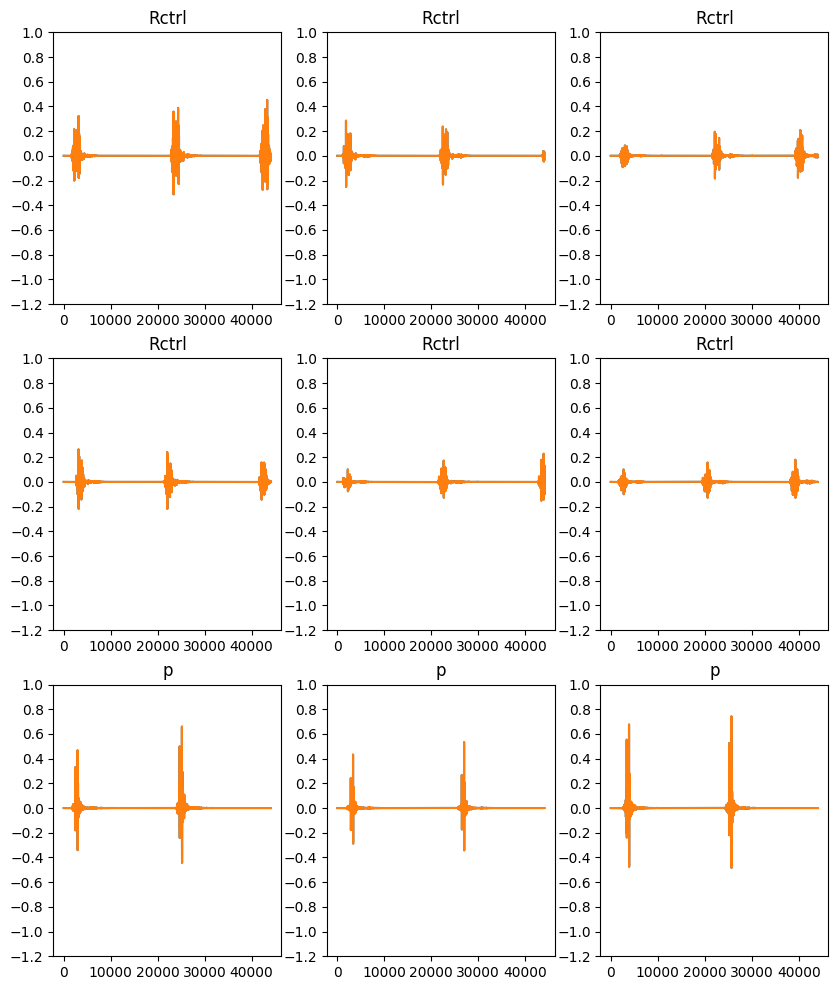

In [121]:
# Load MKA
mka_waveforms, mka_labels = get_MKA_waveforms_and_labels()

# Load supplementary
sup_waveforms, sup_labels = [], []

# Splice
waveforms = mka_waveforms + sup_waveforms
labels = mka_labels + sup_labels


print("Number of samples: ", len(waveforms))

train_files = waveforms
val_files = ""
test_files = ""

# 50 ms interval

# Verify length of audios is 1 second at 44100 Hz
for i, tr_f in enumerate(train_files):
    num_samples = tf.shape(tr_f)[0]  # Length along the first dimension (number of samples)
    num_channels = tf.shape(tr_f)[1] # Length along the second dimension (number of channels)
    if (num_samples != 44100):
        print(f"Waveform {i}: num_samples = {num_samples}, num_channels = {num_channels}")

# print(train_files[0].shape)
# print(train_files[900].shape)
# print(train_files[463].shape)


waveform_and_label_ds = tf.data.Dataset.from_tensor_slices((train_files, labels))
waveform_ds = waveform_and_label_ds.map(lambda x, y: (x, y), num_parallel_calls=tf.data.AUTOTUNE)


print(waveform_ds.element_spec)

rows = 3
cols = 3
n = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()


# Preprocessing

# Spectrogram Generation

In [109]:
def generate_spectrogram():
    pass